### DHO Optimizer comparision

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 08-21-20
<br>**Short description:** Notebook for testing different global optimizer for DHO fitting where local minima is observed very often.

In [16]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys
%matplotlib inline
# see if local stores mpl style, else use from src
try:
    plt.style.use('yu_basic')
except:
    mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)
mpl.rcParams['text.usetex'] = False

In [2]:
# import CARMA celerite term
from agntk.carma.CARMATerm import *
from agntk.lc.utils import *
from celerite import GP
from scipy.optimize import minimize
import celerite

In [3]:
from dask.distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:57278 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [ ]:
clientnt.reset()

### 1. Simulate DHO LC

In [4]:
# define GP model
a1 = 0.03939692
a2 = 0.00027941
b0 = 0.0046724
b1 = 0.0256982
kernel = DHO_term(np.log(a1), np.log(a2), np.log(b0), np.log(b1))
gp = GP(kernel)

# check if Celerite give the same amp as Kali
assert np.allclose(1.0, kernel.get_amp())

In [5]:
# now simulate 10 years LC
npts = 100
nLC = 50

# init with dense -> add season -> downsample
t_init = np.linspace(0, 3650, 10000)
yerr_init = np.random.normal(0, 1e-7, 10000) # give very tiny error
gp.compute(t_init, yerr_init)
y_init = gp.sample(size=nLC)

tArr = np.zeros((nLC, npts))
yArr = np.zeros((nLC, npts))
yerrArr = np.zeros((nLC, npts))

for i in range(nLC):    
    mask1 = add_season(t_init)
    mask2 = downsample_byN(t_init[mask1], npts)
    tArr[i,:] = t_init[mask1][mask2]
    yArr[i,:] = y_init[i][mask1][mask2]
    yerrArr[i,:] = yerr_init[mask1][mask2]


print(f'Mean Sim Std: {np.mean(np.std(yArr, axis=1))}')
print(f'True Std: {1}')

Mean Sim Std: 0.9422534963451139
True Std: 1


Text(0.5, 1.0, 'Simulated DHO LC with Seasonal Gap')

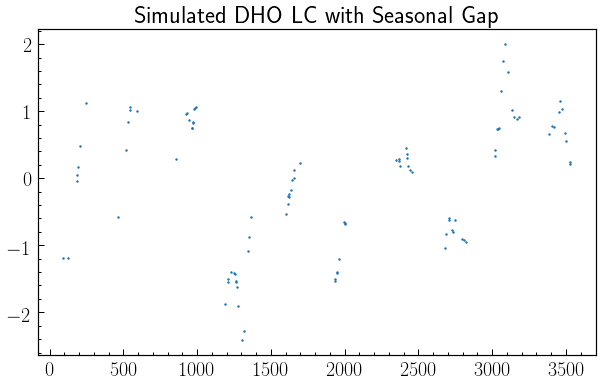

In [6]:
# # plot simulated LC
fig = plt.figure(figsize=(10,6))
plt.scatter(tArr[0], yArr[0], s=2)
plt.title('Simulated DHO LC with Seasonal Gap')

### 2. Test __basin-hopping__ algorithm
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.basinhopping.html#scipy.optimize.basinhopping

In [47]:
from scipy.optimize import basinhopping

# define log posterior function
def neg_log_like_1(params, y, yerr, gp):
    """This method will not catch 'overflow/underflow' runtimeWarning and 
    let the code decide what to return
    """
    notify_method = 'warn'
    np.seterr(over=notify_method)
    np.seterr(under=notify_method)
    
    params = np.array(params)
    run = True
    lap = 0

    while run:
        if lap > 50:
            return -np.inf

        lap += 1
        try:
            gp.set_parameter_vector(params)
            neg_ll = -gp.log_likelihood(y)
            run=False
        except celerite.solver.LinAlgError:
            params += 1e-6*np.random.randn(4)
            continue
        except np.linalg.LinAlgError:
            params += 1e-6*np.random.randn(4)
            continue
            
    return neg_ll

# define log posterior function
def neg_log_like_2(params, y, yerr, gp):
    """This method will catch 'overflow/underflow' runtimeWarning and 
    return -inf as probablility
    """
    # change few runtimewarning action setting
    notify_method = 'raise'
    np.seterr(over=notify_method)
    np.seterr(under=notify_method)
    
    params = np.array(params)
    run = True
    lap = 0

    while run:
        if lap > 50:
            return -np.inf

        lap += 1
        try:
            gp.set_parameter_vector(params)
            neg_ll = -gp.log_likelihood(y)
            run=False
        except celerite.solver.LinAlgError:
            params += 1e-6*np.random.randn(4)
            continue
        except np.linalg.LinAlgError:
            params += 1e-6*np.random.randn(4)
            continue
        except FloatingPointError:
            return -np.inf
            
    return neg_ll
# # # define vectorized version
# vec_neg_log_like = np.vectorize(neg_log_like, excluded=[1,2,3], signature='(n)->()')
# vec_neg_log_prob = np.vectorize(neg_log_prob, excluded=[1,2,3], signature='(n)->()')

In [8]:
# bounds for optimizer
class MyBounds(object):
    def __init__(self, xmin, xmax, **kwargs):
        self.xmax = np.array(xmax)
        self.xmin = np.array(xmin)
     
    def __call__(self, **kwargs):
        x = kwargs["x_new"]
        tmax = bool(np.all(x <= self.xmax))
        tmin = bool(np.all(x >= self.xmin))
        print(kwargs['x_old'], kwargs['x_new'])
#         print(kwargs['x_new'])
        return (tmax and tmin)

xmin=np.array([-10, -14, -12, -11])
xmax=np.array([7, 7, -2, -2])
mybounds = MyBounds(xmin=xmin, xmax=xmax)

In [9]:
def fitDHO_bh_dask(idx, prob_func):
    
    run=True
    t = tArr[idx]
    y = yArr[idx]
    yerr = yerrArr[idx]
    
    while run:
        ## start fitting
        # initialize parameter in the possible range
        a1 = np.exp(np.random.uniform(-10, 1, 1)[0])
        a2 = np.exp(np.random.uniform(-14, -3, 1)[0])
        b0 = np.exp(np.random.uniform(-10, -5, 1)[0])
        b1 = np.exp(np.random.uniform(-10, -5, 1)[0])

        kernel_fit = DHO_term(np.log(a1), np.log(a2), np.log(b0), np.log(b1))
        gp_fit = GP(kernel_fit)
        gp_fit.compute(t, yerr)

        minimizer_kwargs = {"method":"L-BFGS-B", "args": (y, yerr, gp_fit)}
        initial_params = gp_fit.get_parameter_vector()
#         print(f'Init: {initial_params}')
        ret = basinhopping(prob_func, initial_params, minimizer_kwargs=minimizer_kwargs, 
                           niter_success=30, accept_test=mybounds, stepsize=4)
    
        # sometime basinhopping suggest something extremely off in the first
        # iteration and will accept with no condition, this if clause check 
        # whether that's true, if so, redo the whole process
        if np.all(ret.x <= xmax) and np.all(ret.x >= xmin):
            run = False
        
    return ret.x

#### Run with `neg_log_like_1` likelihood function

In [48]:
%%time
ret_all = []
for i in range(nLC):
    ret = client.submit(fitDHO_bh_dask, i, neg_log_like_1)
    ret_all.append(ret)

result1= client.gather(ret_all)

CPU times: user 13.1 s, sys: 1.9 s, total: 15 s
Wall time: 4min 54s


<span style='color:red'>__Note:__ </span> On average 24 sec per fitting/per core

#### Run with `neg_log_like_2` likelihood function

In [49]:
%%time
ret_all = []
for i in range(nLC):
    ret = client.submit(fitDHO_bh_dask, i, neg_log_like_2)
    ret_all.append(ret)

result2= client.gather(ret_all)

CPU times: user 9.96 s, sys: 1.44 s, total: 11.4 s
Wall time: 3min 50s


<span style='color:red'>__Note:__ </span> On average 19 sec per fitting/per core

### 2.1 Plot the Err distribution

Text(0.5, 0, 'Percentage Error')

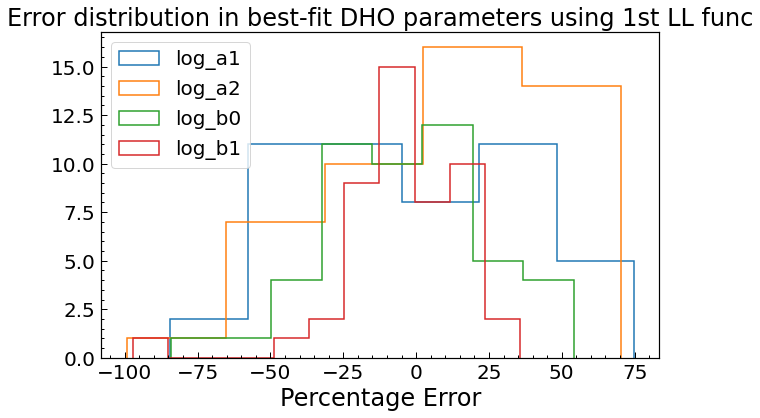

In [63]:
# compute percentage err
input_params = np.exp(gp.parameter_vector)[:4]
best_params = np.exp(np.array(result1))
percent_err = 100*(best_params - input_params)/input_params

param_names = gp.parameter_names
for i in range(4):
    data_range = np.percentile(percent_err[:,i], [1, 99])
    err2plot = percent_err[:,i][(percent_err[:,i]>data_range[0]) & (percent_err[:,i] < data_range[1])]
    plt.hist(err2plot, label=param_names[i].split(':')[1], histtype='step', 
             bins='fd', linewidth=1.5)
plt.legend(loc=2)
plt.title('Error distribution in best-fit DHO parameters using 1st LL func')
plt.xlabel('Percentage Error')

Text(0.5, 0, 'Percentage Error')

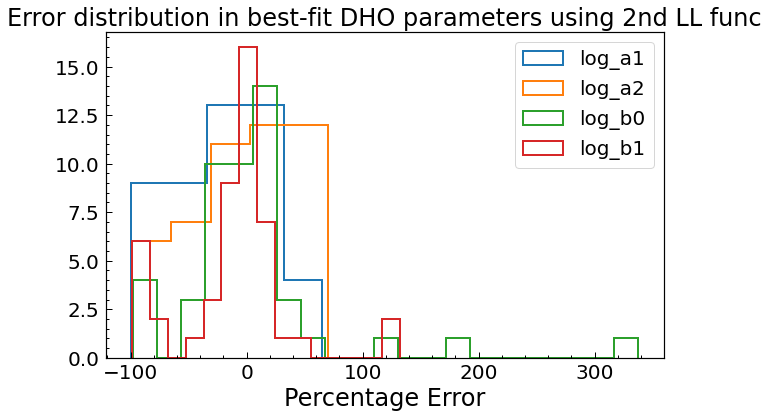

In [64]:
# compute percentage err
input_params = np.exp(gp.parameter_vector)[:4]
best_params = np.exp(np.array(result2))
percent_err = 100*(best_params - input_params)/input_params

param_names = gp.parameter_names
for i in range(4):
    data_range = np.percentile(percent_err[:,i], [1, 99])
    err2plot = percent_err[:,i][(percent_err[:,i]>data_range[0]) & (percent_err[:,i] < data_range[1])]
    plt.hist(err2plot, label=param_names[i].split(':')[1], histtype='step', 
             bins='fd', linewidth=2)
plt.legend()
plt.title('Error distribution in best-fit DHO parameters using 2nd LL func')
plt.xlabel('Percentage Error')

<span style='color:red'>__Note:__ </span>After a series of fine tuning, I am able to reduce the error in best-fit parameter down to +/- 100% with the **basin_hopping**. It is still possible to get best-fit parameter that are quite off, the next level of improvement can come from multiple random initialization for each fit and pick the best one. It is worth **mentioning** that handlinng numerical overflow/underflow in the likelihood function (`neg_log_like_2`) leads to less accurate best-fit parameter. As seen in the figure above, DHO also exhibits similar kind error distribution as the DRW, which cannot be further reduce.

### 3. Test __differential_evolution__ algorithm
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html

In [59]:
from scipy.optimize import rosen, differential_evolution

def fitDHO_de_dask(idx, prob_func):
    
    t = tArr[idx]
    y = yArr[idx]
    yerr = yerrArr[idx]
    
    ## start fitting
    # initialize parameter in the possible range
    a1 = np.exp(np.random.uniform(-10, 1, 1)[0])
    a2 = np.exp(np.random.uniform(-14, -3, 1)[0])
    b0 = np.exp(np.random.uniform(-10, -5, 1)[0])
    b1 = np.exp(np.random.uniform(-10, -5, 1)[0])

    kernel_fit = DHO_term(np.log(a1), np.log(a2), np.log(b0), np.log(b1))
    gp_fit = GP(kernel_fit)
    gp_fit.compute(t, yerr)

    bounds = [(-10, 7), (-14, 7), (-12, -2), (-11, -2)]

    ret = differential_evolution(prob_func, bounds, args=(y, yerr, gp_fit))
    
    return ret.x

In [66]:
%%time
rt1 = []
rt2 = []

for i in range(nLC):
    rt1.append(fitDHO_de_dask(i, neg_log_like_1))
    rt2.append(fitDHO_de_dask(i, neg_log_like_2))

CPU times: user 2min 57s, sys: 16.7 s, total: 3min 14s
Wall time: 3min 2s


<span style='color:red'>__Note:__ </span> On average 2 sec per fitting/per core

### 3.1 Plot error distribution

Text(0.5, 0, 'Percentage Error')

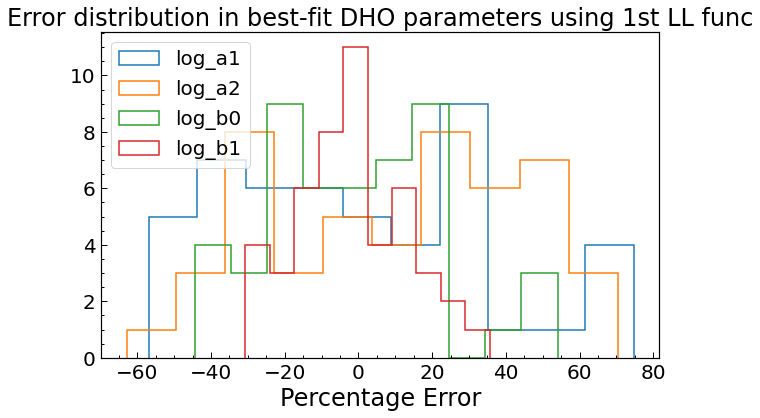

In [69]:
# compute percentage err
input_params = np.exp(gp.parameter_vector)[:4]
best_params = np.exp(np.array(rt1))
percent_err = 100*(best_params - input_params)/input_params

param_names = gp.parameter_names
for i in range(4):
    data_range = np.percentile(percent_err[:,i], [1, 99])
    err2plot = percent_err[:,i][(percent_err[:,i]>data_range[0]) & (percent_err[:,i] < data_range[1])]
    plt.hist(err2plot, label=param_names[i].split(':')[1], histtype='step', 
             bins='fd', linewidth=1.5)
plt.legend(loc=2)
plt.title('Error distribution in best-fit DHO parameters using 1st LL func')
plt.xlabel('Percentage Error')

Text(0.5, 0, 'Percentage Error')

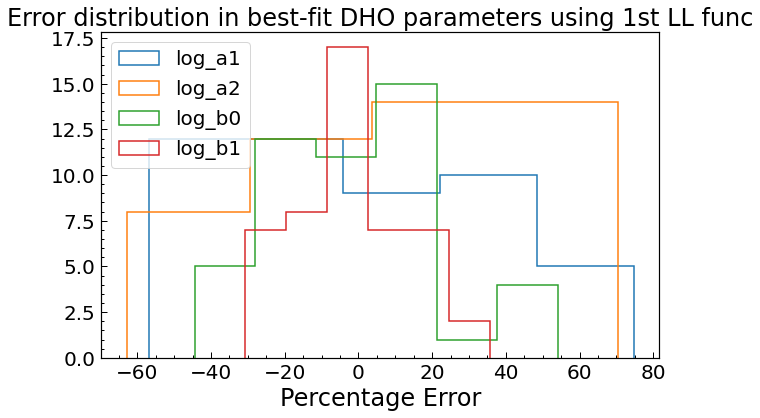

In [68]:
# compute percentage err
input_params = np.exp(gp.parameter_vector)[:4]
best_params = np.exp(np.array(rt2))
percent_err = 100*(best_params - input_params)/input_params

param_names = gp.parameter_names
for i in range(4):
    data_range = np.percentile(percent_err[:,i], [1, 99])
    err2plot = percent_err[:,i][(percent_err[:,i]>data_range[0]) & (percent_err[:,i] < data_range[1])]
    plt.hist(err2plot, label=param_names[i].split(':')[1], histtype='step', 
             bins='fd', linewidth=1.5)
plt.legend(loc=2)
plt.title('Error distribution in best-fit DHO parameters using 2nd LL func')
plt.xlabel('Percentage Error')

<span style='color:red'>__Note:__ </span> Whether handling overflow/underflow doesn't seem make a difference for the differential_evolution algorithm.

### 4. Test __shgo__ algorithm
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.shgo.html#scipy.optimize.shgo

In [100]:
from scipy.optimize import shgo

def fitDHO_shgo_dask(idx, prob_func):
    
    t = tArr[idx]
    y = yArr[idx]
    yerr = yerrArr[idx]

    ## start fitting
    # initialize parameter in the possible range
    a1 = np.exp(np.random.uniform(-10, 1, 1)[0])
    a2 = np.exp(np.random.uniform(-14, -3, 1)[0])
    b0 = np.exp(np.random.uniform(-10, -5, 1)[0])
    b1 = np.exp(np.random.uniform(-10, -5, 1)[0])

    kernel_fit = DHO_term(np.log(a1), np.log(a2), np.log(b0), np.log(b1))
    gp_fit = GP(kernel_fit)
    gp_fit.compute(t, yerr)

    bounds = [(-10, 7), (-14, 7), (-12, -2), (-11, -2)]
    minimizer_kwargs = {"args": (y, yerr, gp_fit)}
    ret = shgo(prob_func, bounds, args=(y, yerr, gp_fit), n=30, iters=5)
        
    return ret.x

#### Run with `neg_log_like_1` likelihood function

In [102]:
%%time
ret_all = []
for i in range(nLC):
    ret = client.submit(fitDHO_shgo_dask, i, neg_log_like_1)
    ret_all.append(ret)

shgo1= client.gather(ret_all)

CPU times: user 31.4 s, sys: 4.28 s, total: 35.7 s
Wall time: 10min 50s


<span style='color:red'>__Note:__ </span> On average 54 sec per fitting/per core

#### Run with `neg_log_like_2` likelihood function

In [103]:
%%time
ret_all = []
for i in range(nLC):
    ret = client.submit(fitDHO_shgo_dask, i, neg_log_like_2)
    ret_all.append(ret)

shgo2= client.gather(ret_all)

CPU times: user 44 s, sys: 5.35 s, total: 49.3 s
Wall time: 11min 15s


<span style='color:red'>__Note:__ </span> On average 56 sec per fitting/per core

### 4.1 Plot error distribution

Text(0.5, 0, 'Percentage Error')

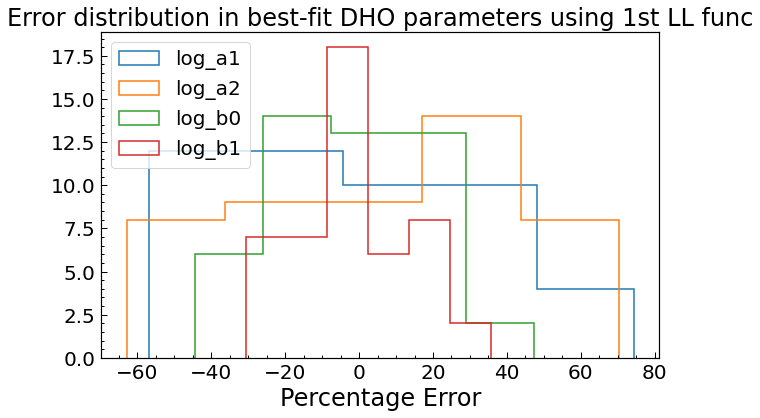

In [104]:
# compute percentage err
input_params = np.exp(gp.parameter_vector)[:4]
best_params = np.exp(np.array(shgo1))
percent_err = 100*(best_params - input_params)/input_params

param_names = gp.parameter_names
for i in range(4):
    data_range = np.percentile(percent_err[:,i], [1, 99])
    err2plot = percent_err[:,i][(percent_err[:,i]>data_range[0]) & (percent_err[:,i] < data_range[1])]
    plt.hist(err2plot, label=param_names[i].split(':')[1], histtype='step', 
             bins='fd', linewidth=1.5)
plt.legend(loc=2)
plt.title('Error distribution in best-fit DHO parameters using 1st LL func')
plt.xlabel('Percentage Error')

Text(0.5, 0, 'Percentage Error')

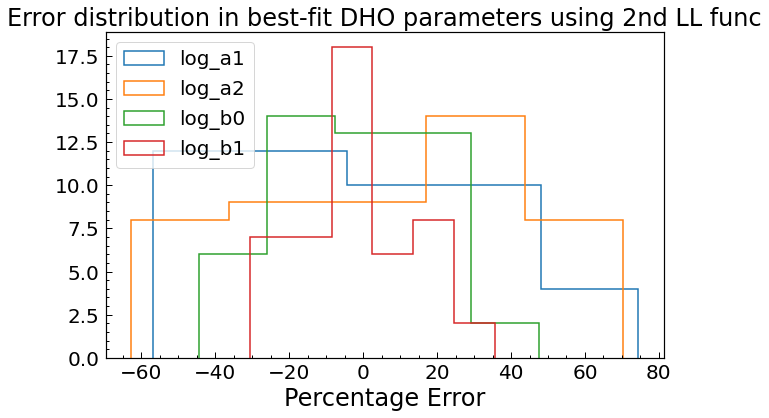

In [107]:
# compute percentage err
input_params = np.exp(gp.parameter_vector)[:4]
best_params = np.exp(np.array(shgo2))
percent_err = 100*(best_params - input_params)/input_params

param_names = gp.parameter_names
for i in range(4):
    data_range = np.percentile(percent_err[:,i], [1, 99])
    err2plot = percent_err[:,i][(percent_err[:,i]>data_range[0]) & (percent_err[:,i] < data_range[1])]
    plt.hist(err2plot, label=param_names[i].split(':')[1], histtype='step', 
             bins='fd', linewidth=1.5)
plt.legend(loc=2)
plt.title('Error distribution in best-fit DHO parameters using 2nd LL func')
plt.xlabel('Percentage Error')

<span style='color:red'>__Note:__ </span> No apparaent difference in accuracy between the two likelihood function, but to get to this level of accuracy, the optimizer needs to run very long. 

### 5. Test __dual_annealing__ algorithm
https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.dual_annealing.html#scipy.optimize.dual_annealing

In [109]:
from scipy.optimize import dual_annealing

def fitDHO_da_dask(idx, prob_func):
    
    # grab lc given index
    t = tArr[idx]
    y = yArr[idx]
    yerr = yerrArr[idx]
    
    ## start fitting
    # initialize parameter in the possible range
    a1 = np.exp(np.random.uniform(-10, 1, 1)[0])
    a2 = np.exp(np.random.uniform(-14, -3, 1)[0])
    b0 = np.exp(np.random.uniform(-10, -5, 1)[0])
    b1 = np.exp(np.random.uniform(-10, -5, 1)[0])

    # init GP object
    kernel_fit = DHO_term(np.log(a1), np.log(a2), np.log(b0), np.log(b1))
    gp_fit = GP(kernel_fit)
    gp_fit.compute(t, yerr)
    
    # fit with bounds
    bounds = [(-10, 7), (-14, 7), (-12, -2), (-11, -2)]
    ret = dual_annealing(prob_func, bounds, args=(y, yerr, gp_fit))
        
    return ret.x

#### Run with `neg_log_like_1` likelihood function

In [114]:
%%time
ret_all = []
for i in range(nLC):
    ret = client.submit(fitDHO_da_dask, i, neg_log_like_1)
    ret_all.append(ret)

da1= client.gather(ret_all)

CPU times: user 13.1 s, sys: 1.55 s, total: 14.6 s
Wall time: 3min 10s


<span style='color:red'>__Note:__ </span> On average 16 sec per fitting/per core (some overhead might be added by dask)

#### Run with `neg_log_like_2` likelihood function

In [115]:
%%time
ret_all = []
for i in range(nLC):
    ret = client.submit(fitDHO_da_dask, i, neg_log_like_2)
    ret_all.append(ret)

da2= client.gather(ret_all)

CPU times: user 12.3 s, sys: 1.43 s, total: 13.7 s
Wall time: 3min 6s


<span style='color:red'>__Note:__ </span> On average 15 sec per fitting/per core (some overhead might be added by dask)

### 5.1 Plot error distribution

Text(0.5, 0, 'Percentage Error')

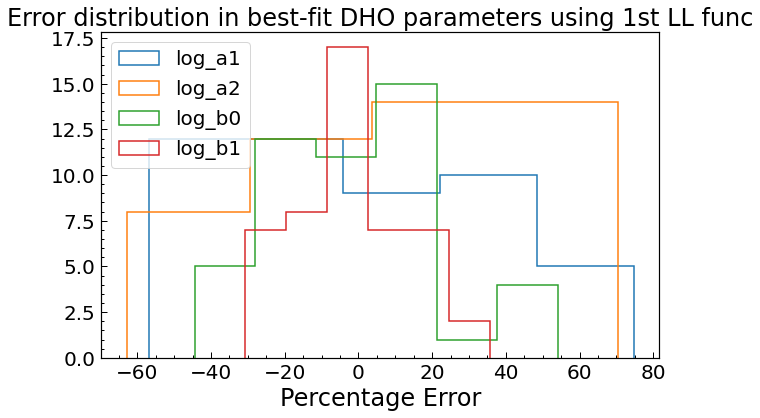

In [116]:
# compute percentage err
input_params = np.exp(gp.parameter_vector)[:4]
best_params = np.exp(np.array(da1))
percent_err = 100*(best_params - input_params)/input_params

param_names = gp.parameter_names
for i in range(4):
    data_range = np.percentile(percent_err[:,i], [1, 99])
    err2plot = percent_err[:,i][(percent_err[:,i]>data_range[0]) & (percent_err[:,i] < data_range[1])]
    plt.hist(err2plot, label=param_names[i].split(':')[1], histtype='step', 
             bins='fd', linewidth=1.5)
plt.legend(loc=2)
plt.title('Error distribution in best-fit DHO parameters using 1st LL func')
plt.xlabel('Percentage Error')

Text(0.5, 0, 'Percentage Error')

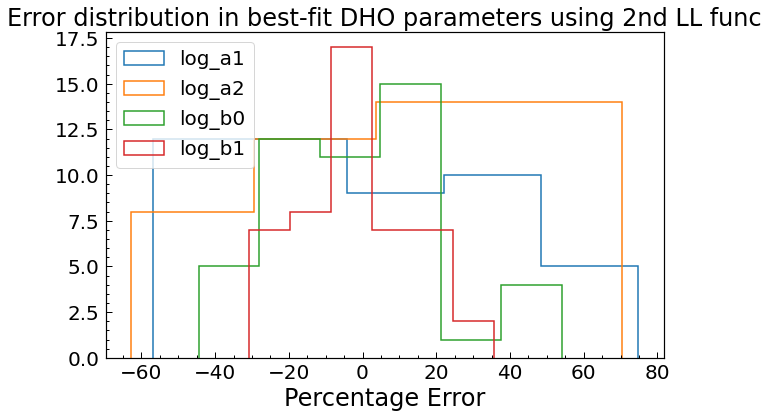

In [117]:
# compute percentage err
input_params = np.exp(gp.parameter_vector)[:4]
best_params = np.exp(np.array(da2))
percent_err = 100*(best_params - input_params)/input_params

param_names = gp.parameter_names
for i in range(4):
    data_range = np.percentile(percent_err[:,i], [1, 99])
    err2plot = percent_err[:,i][(percent_err[:,i]>data_range[0]) & (percent_err[:,i] < data_range[1])]
    plt.hist(err2plot, label=param_names[i].split(':')[1], histtype='step', 
             bins='fd', linewidth=1.5)
plt.legend(loc=2)
plt.title('Error distribution in best-fit DHO parameters using 2nd LL func')
plt.xlabel('Percentage Error')

<span style='color:red'>__Note:__ </span> No difference in accuracy between two `neg_log_like_1` and `neg_log_like_2`. Speed are also similiar, around 15 sec/fitting/core 

<span style='color:red'>__Conclusion:__</span> In the above tests done, the `differential_evolution` algorithm performs the best achieving 2 sec/fit/core with no accuracy loss as compared other top methods. `dual_annealing` algorithm places the second achieving 15 sec/fit/core with the top accuracy. Larger number of tests should be done to better access the difference in accuracy between the above two methods. Certainly, the whether to handle numerical overflow/underflow doesn't matter at all for the top two methods. 